In [1]:
import pandas as pd
import numpy as np
import nibabel as nib
from tqdm import tqdm
import logging
from sklearn.model_selection import StratifiedKFold
import time
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import sys
import os

In [2]:
import matplotlib.pyplot as plt 
from scipy.ndimage.interpolation import zoom

In [3]:
from fastai2.basics import *

In [4]:
data_path = Path('/home/akanksha/brainlabs/projects/brain-transfer')

In [5]:
metadata = pd.read_csv(data_path/'data/metadata.csv')
# metadata.loc[metadata['Path'].str.endswith('nii') == False, :]
metadata = metadata[metadata.Label.isin(('AD', 'CN'))].reset_index(drop=True)
metadata.head()

,Path,Label
0,data/sub-ADNI100S0015_ses-M36_T1w.nii,CN
1,data/sub-ADNI067S0019_ses-M36_T1w.nii,CN
2,data/sub-ADNI011S0021_ses-M96_T1wa.nii,CN
3,data/sub-ADNI011S0023_ses-M96_T1w.nii,CN
4,data/sub-ADNI067S0029_ses-M24_T1w.nii,AD


In [6]:
metadata.Path[0]

'data/sub-ADNI100S0015_ses-M36_T1w.nii'

In [7]:
fn_img = Path(metadata.Path[1]).name

In [8]:
fn_img

'sub-ADNI067S0019_ses-M36_T1w.nii'

/home/ashaw/anaconda3/envs/rsna_retro/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  This is separate from the ipykernel package so we can avoid doing imports until


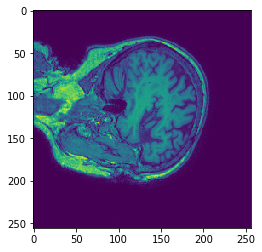

In [9]:
data_path2 = Path('/home/akanksha/brainlabs/projects/brain-seg/data_folder/preprocessing/ADNI/CN')
files = get_files(data_path2, extensions=['.nii'])
a = nib.load(files[0]).get_data()
plt.imshow(a[50])

In [10]:
data_path2

Path('/home/akanksha/brainlabs/projects/brain-seg/data_folder/preprocessing/ADNI/CN')

/home/ashaw/anaconda3/envs/rsna_retro/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  This is separate from the ipykernel package so we can avoid doing imports until


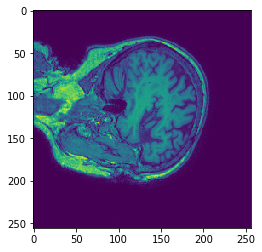

In [11]:
data_path2 = data_path/'data'
files = get_files(data_path2, extensions=['.nii'])
a = nib.load(files[0]).get_data()
plt.imshow(a[50])

/home/ashaw/anaconda3/envs/rsna_retro/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  This is separate from the ipykernel package so we can avoid doing imports until


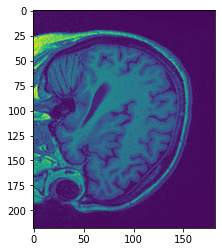

In [12]:
data_path2 = Path('/home/akanksha/brainlabs/projects/brain-seg/data_folder/preprocessing/ADNIReg/CN')
files = get_files(data_path2, extensions=['.gz'])
a = nib.load(files[0]).get_data()
plt.imshow(a[50])

/home/ashaw/anaconda3/envs/rsna_retro/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  This is separate from the ipykernel package so we can avoid doing imports until


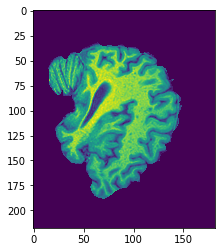

In [13]:
data_path2 = Path('/home/akanksha/brainlabs/projects/brain-seg/data_folder/preprocessing/ADNIBrain/CN')
files = get_files(data_path2, extensions=['.gz'])
a = nib.load(files[0]).get_data()
plt.imshow(a[50])

/home/ashaw/anaconda3/envs/rsna_retro/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.


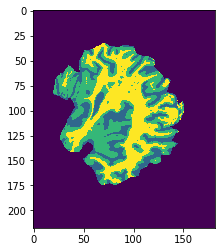

In [14]:
# data_path2 = Path('/home/akanksha/brainlabs/projects/brain-seg/data_folder/preprocessing/ADNI/CN')
data_path2 = Path('/home/akanksha/brainlabs/projects/brain-seg/data_folder/ADNI_denoised_registered_skullstripped/CN')
files = get_files(data_path2, extensions=['.nii'])
a = nib.load(files[0]).get_data()
plt.imshow(a[50])

In [15]:
a = nib.load(data_path/fn_img.name)

AttributeError: 'str' object has no attribute 'name'

In [16]:
img = nib.load(data_path/fn_img).get_data()
img.shape

FileNotFoundError: No such file or no access: '/home/akanksha/brainlabs/projects/brain-transfer/sub-ADNI067S0019_ses-M36_T1w.nii'

In [10]:
def norm(data):
    data = data / float(np.max(data))
    return data

In [11]:
def resize(data, target_shape=[96, 128, 128]):
    factor = [float(t) / float(s) for t, s in zip(target_shape, data.shape)]
    resized = zoom(data, zoom=factor, order=1, prefilter=False)
    #print(resized)
    return resized

In [12]:
n = norm(resize(img))

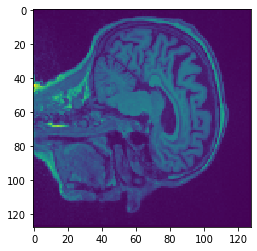

In [13]:
plt.imshow(n[50])

In [14]:
class TfmSOP:
    def __init__(self,df):
        store_attr(self, 'df')
    
    def x(self, idx):
        fn_img = Path(metadata.Path[idx])
        img = img = nib.load(data_path/fn_img).get_data()
        img_n = norm(resize(img))
        return torch.from_numpy(img_n)
    
    def y(self, idx): 
        return int(metadata.Label[idx] == 'AD')

In [15]:
tsop = TfmSOP(metadata)

In [16]:
tfms = [[tsop.x],[tsop.y]]
dsets = Datasets(range(metadata.shape[0]), tfms, splits=RandomSplitter()(range(metadata.shape[0])))

/home/ashaw/anaconda3/envs/rsna_retro/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  import sys


In [17]:
def get_data_gen(fns, bs, img_tfm, splits, sz=None, nw=8, 
                 batch_xtra=None, after_item=None, with_aug=True, test=False, **kwargs):
    tfms = [[tsop.x],[tsop.y]]
    dsets = Datasets(range(metadata.shape[0]), tfms, splits=RandomSplitter()(range(metadata.shape[0])))
    return dsets.dataloaders(bs=bs, num_workers=nw)

In [ ]:
a = get_data_gen()

In [48]:
def preprocess_data(first_class, second_class, results_folder,
                 num_epochs=70, batchsize=3):
    """Iterate minibatches on train subset.

    Parameters
    ----------
    first_class : {'AD', 'LMCI', 'EMCI', 'Normal'}
        String label for target == 0.
    second_class : {'AD', 'LMCI', 'EMCI', 'Normal'}
        String label for target == 1.
    results_folder : string
        Folder to store results.
    num_epochs : integer
        Number of epochs for all of the experiments. Default is 70.
    batchsize : integer
        Batchsize for network training. Default is 3.
    """
    
    if first_class not in {'AD', 'LMCI', 'EMCI', 'Normal', 'CN'}:
        msg = "First class must be 'AD', 'LMCI', 'EMCI', 'CN' or 'Normal', not {0}"
        raise ValueError(msg.format(first_class))
    
    if second_class not in {'AD', 'LMCI', 'EMCI', 'Normal', 'CN'}:
        msg = "Second class must be 'AD', 'LMCI', 'EMCI', 'CN' or 'Normal', not {0}"
        raise ValueError(msg.format(second_class))
        
    if first_class == second_class:
        raise ValueError("Class labels should be different")
        
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
    
    metadata = pd.read_csv('data/metadata.csv')
    smc_mask = ((metadata.Label == first_class) |
                (metadata.Label == second_class)).values.astype('bool')

    data = np.zeros((smc_mask.sum(), 1, 110, 110, 110), dtype='float32')
    
    for it, im in tqdm(enumerate(metadata[smc_mask].Path.values),
                       total=smc_mask.sum(), desc='Reading MRI to memory'):
        img = nib.load(im).get_data()
        mx = img.max(axis=0).max(axis=0).max(axis=0) 
        #print(np.array(resize(img)) / mx)
        data[it, 0, :, :, :] = np.array(resize(img,target_shape=[110, 110, 110])) / mx

    target = (metadata[smc_mask].Label == second_class).values.astype('int32')
    return data,target


In [ ]:
def resize(data, target_shape=[96, 112, 96]):
    factor = [float(t) / float(s) for t, s in zip(target_shape, data.shape)]
    resized = zoom(data, zoom=factor, order=1, prefilter=False)
    #print(resized)
    return resized